In [1]:
import pandas as pd
import numpy as np
from cosine_lr_scheduler import CosineLRScheduler
from custom_tokenizer import BytePairEncodingTokenizer
import re
from string import punctuation
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import tensorflow as tf

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split

# load tokenizer

tokenizer = BytePairEncodingTokenizer()
tokenizer.load_tokenizer('tokenizer.pkl')

tokenizer.maxlen = 256

In [2]:
df = pd.read_csv("/home/bibek/dataset/IMDB Dataset.csv")
X = df.review
Y = df.sentiment.map({'positive':1,'negative':0})

In [3]:
def preprocess_text(x,tweet=False):
    """
    cleaning tweets -> 
    @user -> USER
    urls -> LINK
    keep only !,.:#? and add space 
    """
    x = str(x).replace('&amp;','and').replace('<br />','').replace('&quot;','').lower()
    x = re.sub(r'&#x[0-9A-Fa-f]+;','',x)
    x = re.sub(r'&#\d+;',"'",x)
    x = re.sub(r'[^\x00-\x7F]+', "'",x)
    
    url_pattern = r'http\S+|www\S+'
    x = re.sub(url_pattern, 'LINK', x)
    
    punct_to_keep = """!,.:#?"-;//%$(){}@^*+<=>\\|'"""
    punct = ''.join([p for p in punctuation if p not in punct_to_keep])
    trans = str.maketrans(punct, ' ' * len(punct))
    x = x.translate(trans)
    x = ''.join(x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])\s*\1+', r'\1', x)
    x = re.sub(r'([!"#$%&\()*+,-./:;<=>?@\\^_`{|}~])', r' \1 ', x)
    x = re.sub(r'\s+', ' ', x).strip().replace("'s "," 's ")
    x = x.replace("\\'"," '").replace("'"," ' ")
    x = x + ' '
    return re.sub(r'\s+', ' ', x).strip()

In [4]:
# preprocess, tokenize and pad sequences

X = [preprocess_text(x) for x in tqdm(X)]
X = [tokenizer.tokenize(x) for x in tqdm(X)]
X = np.array([tokenizer.add_padding(x) for x in tqdm(X)],np.int16)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

In [5]:
# split data in train, test and val

xtrain,xtest,ytrain,ytest = train_test_split(X,Y,train_size=0.7,random_state=10)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,train_size=0.66,random_state=10)

In [6]:
# define training params

MAXLEN = tokenizer.maxlen
PEAK_LR = 2e-4
END_LR = 1e-7
INIT_LR = 0
WARMUP_RATE = 0.05
BATCH = 32
EPOCHS = 3

# load and build model

model = tf.keras.models.load_model("robust_net.keras")
i1 = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)
i2 = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)
model([i1,i2])

# load pretrained weights
model.load_weights("robust_net.weights.h5")

2025-05-16 18:35:03.166045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-16 18:35:03.177592: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-16 18:35:03.181038: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 18:35:03.189745: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-16 18:35:03.836682: W tensorflow/compiler/tf2

In [7]:
# for text classification task, we only need the embedding and encoder
# extract embedding and encoder layer

fact_emb_layer = model.layers[0]
encoder = model.layers[1]

# build the model 

i = tf.keras.layers.Input((MAXLEN,),batch_size=BATCH)
x,mask = fact_emb_layer(i)
x = encoder([x,mask])
x = tf.keras.layers.GlobalAveragePooling1D()(x)
o = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(i,o)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (32, 256)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ factorized_embeddi… │ [(32, 256, 256),  │  1,957,760 │ input_layer_2[0]… │
│ (FactorizedEmbeddi… │ (32, 256)]        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block       │ (32, 256, 256)    │  1,054,208 │ factorized_embed… │
│ (EncoderBlock)      │                   │            │ factorized_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (32, 256)         │          0 │ encoder_block[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (32, 1)           │        257 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,012,225 (11.49 MB)

 Trainable params: 3,012,225 (11.49 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# initialize loss function and optimizer

loss_fn = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.AdamW(weight_decay=0.01)

# prepare data as tensor for training

train = tf.data.Dataset.from_tensor_slices((xtrain,ytrain))
train = train.batch(batch_size=BATCH).shuffle(buffer_size=100)

valid = tf.data.Dataset.from_tensor_slices((xval,yval)).batch(batch_size=BATCH)

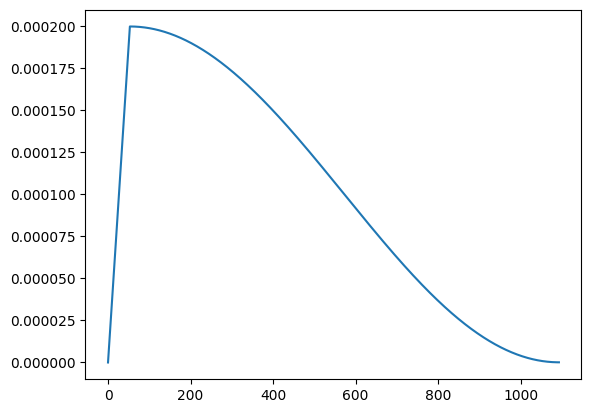

In [9]:
# define lr scheduling

total_steps = len(xtrain) // BATCH + 1

lr_scheduler = CosineLRScheduler(total_steps,peak_lr=PEAK_LR,init_lr=INIT_LR,
                                 min_lr=END_LR,warmup_rate=WARMUP_RATE)

plt.plot([lr_scheduler(i) for i in range(1,total_steps+1)])

In [10]:
@tf.function
def train_step(x,y,model):
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        loss = loss_fn(y,pred)
    weights = model.trainable_weights
    grads = tape.gradient(loss,weights)
    opt.apply_gradients(zip(grads,weights))
    return loss


@tf.function
def test_step(x,y,model):
    pred = model(x,training=False)
    loss = loss_fn(y,pred)
    return loss

In [11]:
# model training loop

losses = {'train':[],'valid':[]}

for e in range(1,EPOCHS+1):
    
    print(f'EPOCH : {e}/{EPOCHS}')
    
    loss = 0
    for i,(x,y) in enumerate(tqdm(train)):
        lr = lr_scheduler(i+1)
        opt.learning_rate.assign(lr)
        loss += train_step(x,y,model)
        
    train_loss = np.round((loss / (i+1)).numpy(),4)
    
    losses['train'].append(train_loss)
    
    loss = 0
    for i,(x,y) in enumerate(valid):
        loss += test_step(x,y,model)
        
    
    loss = np.round((loss / (i+1)).numpy(),4) 
    
    print('train_loss :',train_loss)
    print('val_loss :',loss)
    
    if e == 1:
        model.save_weights(f'saved_weights.weights.h5')
        print('weights saved')
        
    elif e > 1 and min(losses['valid']) > loss:
        model.save_weights(f'saved_weights.weights.h5')
        print('weights saved')
    
    losses['valid'].append(loss)
    print()

EPOCH : 1/3


  0%|          | 0/1094 [00:00<?, ?it/s]

2025-05-16 18:36:48.424997: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


train_loss : 0.3951
val_loss : 0.3236
weights saved

EPOCH : 2/3


2025-05-16 18:36:52.046569: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1094 [00:00<?, ?it/s]

train_loss : 0.3053
val_loss : 0.3033
weights saved

EPOCH : 3/3


2025-05-16 18:38:02.060524: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  0%|          | 0/1094 [00:00<?, ?it/s]

train_loss : 0.2642
val_loss : 0.2993
weights saved



In [12]:
# load best weights

model.load_weights('saved_weights.weights.h5')

In [13]:
# get metrics for test data

test = tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=BATCH)

preds = []

for i,(x,y) in enumerate(test):
    mask = x == 0
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(ytest,preds))
print('f1_score :',f1_score(ytest.values,preds))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      5005
           1       0.86      0.88      0.87      4895

    accuracy                           0.87      9900
   macro avg       0.87      0.87      0.87      9900
weighted avg       0.87      0.87      0.87      9900

f1_score : 0.8714733542319749


In [15]:
# get metrics for val data

preds = []

for i,(x,y) in enumerate(valid):
    mask = x == 0
    p = np.round(model(x).numpy()[:,0])
    preds.extend(p)
    
print(classification_report(yval,preds))
print('f1_score :',f1_score(yval.values,preds))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2590
           1       0.87      0.88      0.87      2510

    accuracy                           0.87      5100
   macro avg       0.87      0.87      0.87      5100
weighted avg       0.87      0.87      0.87      5100

f1_score : 0.8715814506539834
